This notebook contains the analysis code for the number and proportion of local places mentionned in articles. This is the first part of the analysis section in the paper.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
with open('../analysis/queries.p', 'rb') as f:
    queries = pickle.load(f)
with open('../analysis/pub2loc.p', 'rb') as f:
    pub2loc = pickle.load(f)

In [5]:
id2place = {v[0]['place_id']: {'entity':k[0], 'result':v} 
                                    for k,v in queries.items()}

### LA Weekly

In [23]:
# load LAW data 
with open('../data/places/la/pre-weeks.p', 'rb') as f:
    pre_weeks_la = pickle.load(f)
with open('../data/places/la/post-weeks.p', 'rb') as f:
    post_weeks_la = pickle.load(f)

In [19]:
# load LAW data (pandemic cut out of data)
with open('../data/places/la/pre-weeks-cut.p', 'rb') as f:
    pre_weeks_la = pickle.load(f)
with open('../data/places/la/post-weeks-cut.p', 'rb') as f:
    post_weeks_la = pickle.load(f)

In [20]:
# get coordindates 
la_city_loc = queries[('LOS ANGELES', 'CA')][0]['geometry']['location'].values()

In [21]:
from locality import periods2distances
# compute the distances from the center of the city
la_pre_distances = periods2distances(pre_weeks_la, lambda x: la_city_loc)
la_post_distances = periods2distances(post_weeks_la, lambda x: la_city_loc)

In [22]:
from locality import add_ratios, periods2bool, within_dist_prop

# set parameter ranges
dist_range = np.arange(20, 55, 5)
ratio_range = np.arange(.05, 1.05, .05)

# we are computing both the number and proportion
la_pre_locals_prop, la_post_locals_prop = {dist:[] for dist in dist_range}, {dist:[] for dist in dist_range} 
la_pre_locals_cnt, la_post_locals_cnt = {dist:[] for dist in dist_range}, {dist:[] for dist in dist_range}

# iterate over all parameter tuples
for dist in tqdm(dist_range):
    for required_ratio in ratio_range:
        # proportion of local articles 
        la_pre_locals_prop[dist].append(periods2bool(la_pre_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))
        la_post_locals_prop[dist].append(periods2bool(la_post_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))
        # number of local articles 
        la_pre_locals_cnt[dist].append(periods2bool(la_pre_distances, 
                            lambda article: within_dist_prop(article, dist, required_ratio), ratio=False))
        la_post_locals_cnt[dist].append(periods2bool(la_post_distances, 
                            lambda article: within_dist_prop(article, dist, required_ratio), ratio=False))
    
    # append ratios for bookeeping/analysis purposes
    la_pre_locals_prop[dist] = add_ratios(la_pre_locals_prop[dist], ratio_range)
    la_post_locals_prop[dist] = add_ratios(la_post_locals_prop[dist], ratio_range)
    la_pre_locals_cnt[dist] = add_ratios(la_pre_locals_cnt[dist], ratio_range)
    la_post_locals_cnt[dist] = add_ratios(la_post_locals_cnt[dist], ratio_range)

In [23]:
import scipy.stats

In [24]:
pre_cnts = list(chain(*[[row[-2] 
        for row in list(chain(*ratios))] for dist, ratios in la_pre_locals_cnt.items()]))
post_cnts = list(chain(*[[row[-2] for row in list(chain(*ratios))] 
        for dist, ratios in la_post_locals_cnt.items()]))

In [25]:
print('------ Counts ------')
print('Means: ', np.mean(pre_cnts), np.mean(post_cnts))
print('Significance test:', scipy.stats.mannwhitneyu(pre_cnts, post_cnts))
print('%Δ:', (np.mean(post_cnts) - np.mean(pre_cnts))/np.mean(pre_cnts))

------ Counts ------
Means:  32.223076923076924 22.71679748822606
Significance test: MannwhitneyuResult(statistic=62115241.0, pvalue=4.199001399586215e-231)
%Δ: -0.2950146398974964


In [26]:
print('------ Counts (dates cut) ------')
print('Means: ', np.mean(pre_cnts), np.mean(post_cnts))
print('Significance test:', scipy.stats.mannwhitneyu(pre_cnts, post_cnts))
print('%Δ:', (np.mean(post_cnts) - np.mean(pre_cnts))/np.mean(pre_cnts))

------ Counts (dates cut) ------
Means:  32.223076923076924 22.71679748822606
Significance test: MannwhitneyuResult(statistic=62115241.0, pvalue=4.199001399586215e-231)
%Δ: -0.2950146398974964


In [27]:
pre_props = list(chain(*[[row[-2] for row in list(chain(*ratios))] for dist, ratios in la_pre_locals_prop.items()]))
post_props = list(chain(*[[row[-2] for row in list(chain(*ratios))] for dist, ratios in la_post_locals_prop.items()]))

In [28]:
print('------ Proportions ------')
print('Means: ', np.mean(pre_props), np.mean(post_props))
print('Significance test:', scipy.stats.mannwhitneyu(pre_props, post_props))
print('%Δ:', (np.mean(post_props) - np.mean(pre_props))/np.mean(pre_props))

------ Proportions ------
Means:  0.4232440454815223 0.44492139358472377
Significance test: MannwhitneyuResult(statistic=76145413.5, pvalue=7.24022399864127e-18)
%Δ: 0.051217136625133844


In [29]:
print('------ Proportions ------')
print('Means: ', np.mean(pre_props), np.mean(post_props))
print('Significance test:', scipy.stats.mannwhitneyu(pre_props, post_props))
print('%Δ:', (np.mean(post_props) - np.mean(pre_props))/np.mean(pre_props))

------ Proportions ------
Means:  0.4232440454815223 0.44492139358472377
Significance test: MannwhitneyuResult(statistic=76145413.5, pvalue=7.24022399864127e-18)
%Δ: 0.051217136625133844


In [30]:
proportions = [[p, 'pre'] for p in pre_props] + [[p, 'post'] for p in post_props] 
counts = [[p, 'pre'] for p in pre_cnts] + [[p, 'post'] for p in post_cnts] 
df_la_prop = pd.DataFrame(proportions, columns=['num', 'Period'])
df_la_cnts = pd.DataFrame(counts, columns=['num', 'Period'])

### NYD News

In [31]:
# load NYD data
with open('../data/places/ny/pre-weeks.p', 'rb') as f:
    ny_pre_weeks = pickle.load(f)
# note that there are less post-weeks because of a suspicious trend in the data
with open('../data/places/ny/post-weeks.p', 'rb') as f:
    ny_post_weeks = pickle.load(f)

In [32]:
ny_city_locs = [queries[('Queens', 'NY')][0]['geometry']['location'].values(), 
             queries[('The Bronx', 'NY')][0]['geometry']['location'].values(),
             queries[('Staten Island', 'NY')][0]['geometry']['location'].values(),
             queries[('Brooklyn', 'NY')][0]['geometry']['location'].values(),
             queries[('Manhattan', 'NY')][0]['geometry']['location'].values()]

In [33]:
from locality import get_city
def get_sublocality(result):
    try:
        return [part['short_name'] for part in result['address_components'] 
                    if part['types'] == ['political', 'sublocality', 'sublocality_level_1']][0]
    except IndexError:
        return -1

def within_city_prop(article, prop):
    cnt = 0
    for place in article:
        if get_sublocality(place['result'][0]) in ['Staten Island', 'Manhattan','Brooklyn','The Bronx', 'Queens'] \
        or get_city(place['result'][0]) == 'New York':
            cnt+=1
        else:
            continue
    return cnt/len(article) >= prop if len(article) != 0 else False

In [34]:
from locality import within_dist_prop, get_dist, periods2distances

# for NYD we modify our functions so that the distance is the
# minimal distance from the center of the 5 boroughs

def article2distances(places, city_locs):
    distances = []
    for place in places:
        if len(place['result']) > 1:
            place = resolve(place, pub=pub)
        place_loc = place['result'][0]['geometry']['location'].values()
        # 5 boroughs in NYC, take minimal distance
        distances.append(min(get_dist(place_loc, city_loc) for city_loc in city_locs))
    return distances

def articles2distances(articles, city_locs):
    return [[url, article2distances(article, city_locs(url))] for url, article in articles]

def periods2distances(periods, city_locs):
    '''  city_loc is a fct from url -> loc '''
    return {date:articles2distances(articles, city_locs)
                     for date, articles in periods.items() if len(articles) > 0}

In [35]:
# compute distances from closest city-center
ny_pre_distances = periods2distances(ny_pre_weeks, lambda x: ny_city_locs)
ny_post_distances = periods2distances(ny_post_weeks, lambda x: ny_city_locs)

In [36]:
# set parameter ranges
dist_range = np.arange(20, 55, 5)
ratio_range = np.arange(.05, 1.05, .05)

# intialize dicts for prop and cnts
ny_pre_locals_prop, ny_post_locals_prop = {dist:[] for dist in dist_range}, {dist:[] for dist in dist_range} 
ny_pre_locals_cnt, ny_post_locals_cnt = {dist:[] for dist in dist_range}, {dist:[] for dist in dist_range}

# iterate over all parameter tuples
for dist in tqdm(dist_range):
    for required_ratio in ratio_range:
        # proportion of local articles 
        ny_pre_locals_prop[dist].append(periods2bool(ny_pre_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))
        ny_post_locals_prop[dist].append(periods2bool(ny_post_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))

        # number of local articles 
        ny_pre_locals_cnt[dist].append(periods2bool(ny_pre_distances, 
                            lambda article: within_dist_prop(article, dist, required_ratio), ratio=False))
        ny_post_locals_cnt[dist].append(periods2bool(ny_post_distances, 
                            lambda article: within_dist_prop(article, dist, required_ratio), ratio=False))
    
    ny_pre_locals_prop[dist] = add_ratios(ny_pre_locals_prop[dist], ratio_range)
    ny_post_locals_prop[dist] = add_ratios(ny_post_locals_prop[dist], ratio_range)
    ny_pre_locals_cnt[dist] = add_ratios(ny_pre_locals_cnt[dist], ratio_range)
    ny_post_locals_cnt[dist] = add_ratios(ny_post_locals_cnt[dist], ratio_range)

In [37]:
pre_cnts = list(chain(*[[row[-2] 
        for row in list(chain(*ratios))] for dist, ratios in ny_pre_locals_cnt.items()]))
post_cnts = list(chain(*[[row[-2] for row in list(chain(*ratios))] 
        for dist, ratios in ny_post_locals_cnt.items()]))

In [38]:
print('------ Counts ------')
print('Means: ', np.mean(pre_cnts), np.mean(post_cnts))
print('Significance test:', scipy.stats.mannwhitneyu(pre_cnts, post_cnts))
print('%Δ:', (np.mean(post_cnts) - np.mean(pre_cnts))/np.mean(pre_cnts))

------ Counts ------
Means:  50.848626373626374 37.605405405405406
Significance test: MannwhitneyuResult(statistic=11997228.0, pvalue=1.5320351581490178e-263)
%Δ: -0.2604440259784445


In [39]:
pre_props = list(chain(*[[row[-2] 
            for row in list(chain(*ratios))] for dist, ratios in ny_pre_locals_prop.items()]))
post_props = list(chain(*[[row[-2] 
            for row in list(chain(*ratios))] for dist, ratios in ny_post_locals_prop.items()]))

In [40]:
print('------ Proportions ------')
print('Means: ', np.mean(pre_props), np.mean(post_props))
print('Significance test:', scipy.stats.mannwhitneyu(pre_props, post_props))
print('%Δ:', (np.mean(post_props) - np.mean(pre_props))/np.mean(pre_props))

------ Proportions ------
Means:  0.24300770085315204 0.26222343003826015
Significance test: MannwhitneyuResult(statistic=17127040.0, pvalue=1.2390498154786374e-18)
%Δ: 0.07907456890314785


In [41]:
proportions = [[p, 'pre'] for p in pre_props] + [[p, 'post'] for p in post_props] 
counts = [[p, 'pre'] for p in pre_cnts] + [[p, 'post'] for p in post_cnts] 
df_ny_prop = pd.DataFrame(proportions, columns=['num', 'period'])
df_ny_cnts = pd.DataFrame(counts, columns=['num', 'period'])

### DP

In [6]:
with open('../data/places/dp/dp-weeks.p', 'rb') as f:
    weeks = pickle.load(f)
with open('../data/places/dp/dp-years.p', 'rb') as f:
    years = pickle.load(f)

In [11]:
from locality import within_dist_prop, get_dist, resolve
from locality import add_ratios, periods2bool, within_dist_prop

city_loc = queries[('Denver', 'CO')][0]['geometry']['location'].values()

def article2distances(places, city_loc):
    distances = []
    for place in places:
        if len(place['result']) > 1:
            place = resolve(place, pub=pub)
        place_loc = place['result'][0]['geometry']['location'].values()
        distances.append(get_dist(place_loc, city_loc))
    return distances

def articles2distances(articles, city_loc):
    return [[url, article2distances(article, city_loc(url))] for url, article in articles]

def periods2distances(periods, city_loc):
    ''' city_loc is a fct from url -> loc '''
    return {date:articles2distances(articles, city_loc)
                     for date, articles in periods.items() if len(articles) > 0}

In [8]:
# compute distances 
distances = {year : periods2distances(weeks, lambda x: city_loc) 
             for year, weeks in tqdm(years.items())}

In [12]:
dist_range = np.arange(20, 55, 5)
ratio_range = np.arange(.05, 1.05, .05)

props = {year:{dist:{} for dist in dist_range} for year in range(2008,2020)}
cnts =  {year:{dist:{} for dist in dist_range} for year in range(2008,2020)}

for year, weeks in tqdm(distances.items()):
    for dist in dist_range:
        for required_ratio in ratio_range:
            props[year][dist][required_ratio] = periods2bool(weeks, 
                                lambda article: within_dist_prop(article, dist, required_ratio))
            cnts[year][dist][required_ratio] = periods2bool(weeks, 
                                lambda article: within_dist_prop(article, dist, required_ratio), ratio=False)

In [13]:
yearly_cnts = []
for year, dists in cnts.items():
     for dist, ratios in dists.items():
            for ratio, vals in ratios.items():
                for val in vals:
                    yearly_cnts.append([val[-1], year])
yearly_props = [] 
for year, dists in props.items():
     for dist, ratios in dists.items():
            for ratio, vals in ratios.items():
                for val in vals:
                    yearly_props.append([val[-1], year])

In [14]:
cnts_2011 = [c[0] for c in yearly_cnts if c[1] == 2011]
cnts_2018 = [c[0] for c in yearly_cnts if c[1] == 2018]

In [15]:
(np.mean(cnts_2018) - np.mean(cnts_2011))/np.mean(cnts_2011)

-0.6814179739754347

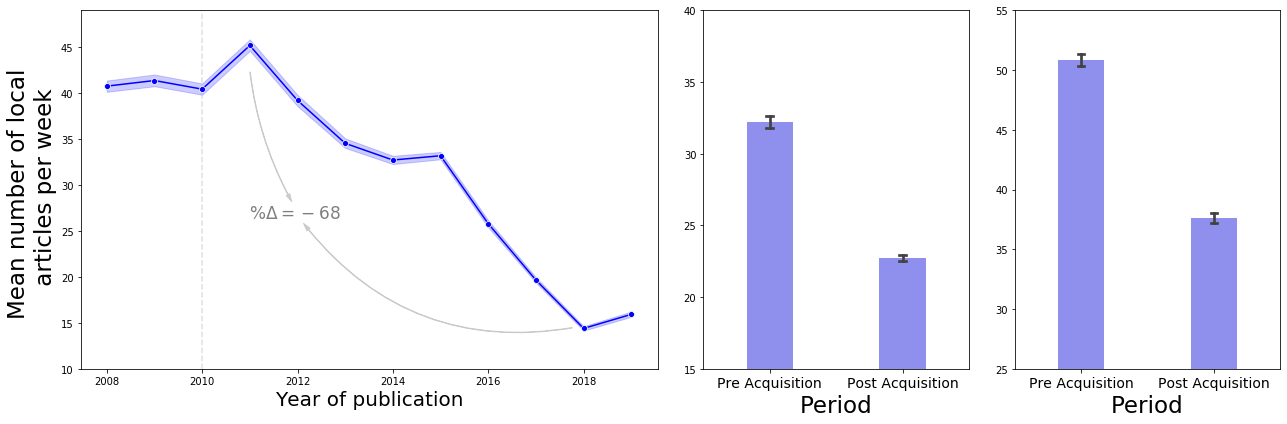

In [47]:
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(18, 6))
gs=GridSpec(1,4)

ax=fig.add_subplot(gs[0,0:2]) 
ax_la=fig.add_subplot(gs[0,2]) 
ax_ny=fig.add_subplot(gs[0,3]) 

cnt_df = pd.DataFrame(yearly_cnts, columns=['count','year'])
prop_df = pd.DataFrame(yearly_props, columns=['prop','year'])    

ax.axvline(x=2010, color='silver', linestyle='--', alpha=0.5)
ax = sns.lineplot(x="year", 
                  y="count", 
                  data=cnt_df, 
                  color='b', 
                  ci=95,
                  ax=ax,
                  marker='o')
    
ax.set_ylim(10, 49)
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="silver", alpha=0.75)

a1 = patches.FancyArrowPatch((2011, 42.5), (2011.9, 28), connectionstyle="arc3,rad=.1", **kw)
a2 = patches.FancyArrowPatch((2017.8, 14.5), (2012.1, 26), connectionstyle="arc3,rad=-.3", **kw)
fig.text(0.23, 0.485, '%$\Delta = -68$', color='grey', weight='roman', ha='center', size=17)
ax.add_patch(a1)
ax.add_patch(a2)
#ax2.set_ylabel('Mean prop. local\n articles per week', size=14)
#ax2.set_xlabel('Year of publication', size=15)
ax.set_xlabel('Year of publication', size=20)
ax.set_ylabel('Mean number of local \n articles per week', size=23)

ax_la = sns.barplot(x="Period", y="num", data=df_la_cnts, color='b',
                       ci=95,
                       ax=ax_la, alpha=.5, capsize=.05)
ax_la.set_xticklabels(['Pre Acquisition','Post Acquisition'], size = 14)

ax_la.set_ylim(15, 40)

change_width(ax_la, .35)
ax_la.set_ylabel(' ')
ax_la.set_xlabel(' ')


df = pd.read_csv('ny-cnts-week.csv')
ax_ny = sns.barplot(x="Period", y="num", data=df, color='b',
                       ci=95,
                       ax=ax_ny, alpha=.5, capsize=.05)
ax_ny.set_xticklabels(['Pre Acquisition','Post Acquisition'], size = 14)
ax_ny.set_ylim(25, 55)
change_width(ax_ny, .35)
#change_width(ax3, .35)
ax_ny.set_ylabel(' ')
ax_ny.set_xlabel('Period', size=23)
ax_la.set_xlabel('Period', size=23)

fig.tight_layout()
plt.savefig('absolute-local-three.png', dpi=300)

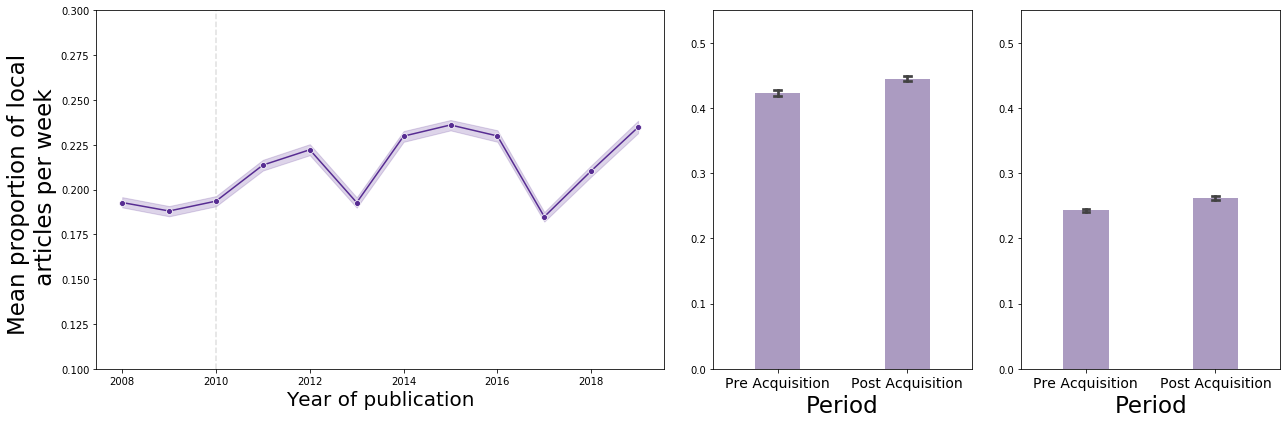

In [46]:
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(18, 6))
gs=GridSpec(1,4)

ax=fig.add_subplot(gs[0,0:2]) 
ax_la=fig.add_subplot(gs[0,2]) 
ax_ny=fig.add_subplot(gs[0,3]) 

cnt_df = pd.DataFrame(yearly_cnts, columns=['count','year'])
prop_df = pd.DataFrame(yearly_props, columns=['prop','year'])    

ax.axvline(x=2010, color='silver', linestyle='--', alpha=0.5)
ax = sns.lineplot(x="year", 
                  y="prop", 
                  data=prop_df, 
                  color=sns.color_palette('Purples')[-1], 
                  ci=95,
                  ax=ax,
                  marker='o')
    
ax.set_ylim(0.1, .3)
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="silver", alpha=0.75)

#a1 = patches.FancyArrowPatch((2011, 42.5), (2011.9, 28), connectionstyle="arc3,rad=.1", **kw)
#a2 = patches.FancyArrowPatch((2017.8, 14.5), (2012.1, 26), connectionstyle="arc3,rad=-.3", **kw)
#fig.text(0.23, 0.485, '%$\Delta = -67$', color='grey', weight='roman', ha='center', size=17)
#ax.add_patch(a1)
#ax.add_patch(a2)
#ax2.set_ylabel('Mean prop. local\n articles per week', size=14)
#ax2.set_xlabel('Year of publication', size=15)
ax.set_xlabel('Year of publication', size=20)
ax.set_ylabel('Mean proportion of local \n articles per week', size=23)

ax_la = sns.barplot(x="Period", y="num", data=df_la_prop, color=sns.color_palette('Purples')[-1],
                       ci=95,
                       ax=ax_la, alpha=.5, capsize=.05)
ax_la.set_xticklabels(['Pre Acquisition','Post Acquisition'], size = 14)

ax_la.set_ylim(0, .55)

change_width(ax_la, .35)
ax_la.set_ylabel(' ')
ax_la.set_xlabel(' ')


df = pd.read_csv('ny-props-week.csv')
ax_ny = sns.barplot(x="Period", y="num", data=df, color=sns.color_palette('Purples')[-1],
                       ci=95,
                       ax=ax_ny, alpha=.5, capsize=.05)
ax_ny.set_xticklabels(['Pre Acquisition','Post Acquisition'], size = 14)
ax_ny.set_ylim(0, .55)
change_width(ax_ny, .35)
#change_width(ax3, .35)
ax_ny.set_ylabel(' ')
ax_ny.set_xlabel('Period', size=23)
ax_la.set_xlabel('Period', size=23)

fig.tight_layout()
plt.savefig('relative-local-three.png', dpi=300)

### DFM California (a.k.a MNG)

In [8]:
# load DFM data
with open('../data/places/dfm/shared-weeks-cut.p', 'rb') as f:
    s_weeks = pickle.load(f)
with open('../data/places/dfm/nonshared-weeks-cut.p', 'rb') as f:
    ns_weeks = pickle.load(f)

In [9]:
all_s_urls = [[a[0].split('/')[2] for a in articles] for period, articles in s_weeks.items()]
all_ns_urls = [[a[0].split('/')[2] for a in articles] for period, articles in ns_weeks.items()]
all_urls =  np.unique(list(chain(*all_s_urls))+list(chain(*all_ns_urls)))

In [14]:
cities = np.unique([get_city(pub2loc[url]) for url in all_urls])

In [15]:
city2loc = {city: queries[(city, 'CA')][0]['geometry']['location'].values() for city in cities}

In [16]:
from locality import within_dist_prop, get_dist, periods2distances
s_distances = periods2distances(s_weeks, lambda url: city2loc[get_city(pub2loc[url.split('/')[2]])])
ns_distances = periods2distances(ns_weeks, lambda url: city2loc[get_city(pub2loc[url.split('/')[2]])])

In [14]:
from locality import add_ratios, periods2bool
dist_range = np.arange(25, 55, 5)
ratio_range = np.arange(.05, 1.05, .05)

# we are only computing proportions since we did not sample uniformly
s_locals_prop, ns_locals_prop = {dist:[] for dist in dist_range}, {dist:[] for dist in dist_range} 

for dist in tqdm(dist_range):
    for required_ratio in ratio_range:
        # proportion of local articles 
        s_locals_prop[dist].append(periods2bool(s_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))
        ns_locals_prop[dist].append(periods2bool(ns_distances, 
                                    lambda article: within_dist_prop(article, dist, required_ratio)))

    s_locals_prop[dist] = add_ratios(s_locals_prop[dist], ratio_range)
    ns_locals_prop[dist] = add_ratios(ns_locals_prop[dist], ratio_range)

In [15]:
from utils import add_distances
s_locals_prop = add_distances(s_locals_prop)
ns_locals_prop = add_distances(ns_locals_prop)

shared_props = list(chain(*[list(chain(*[[w[1] for w in weeks] for weeks in ratios])) 
                      for dist, ratios in s_locals_prop.items()]))
non_shared_props = list(chain(*[list(chain(*[[w[1] for w in weeks] for weeks in ratios])) 
                      for dist, ratios in ns_locals_prop.items()]))

In [16]:
print('Mean: ', np.mean(shared_props), np.mean(non_shared_props))

Mean:  0.13903273262120433 0.47370838813423266


In [ ]:
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

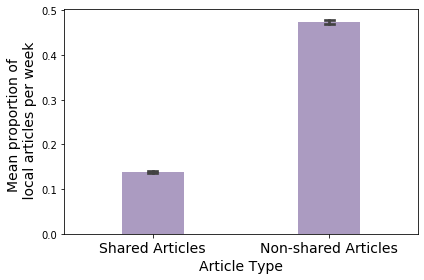

In [20]:
fig = plt.figure()
data = pd.DataFrame([[x, 'shared'] for x in shared_props] + [[x, 'non-shared'] for x in non_shared_props],
                    columns=['proportion', 'class'])
ax = sns.barplot(x="class", y="proportion", data=data, color=sns.color_palette('Purples')[-1],
                       ci=95, alpha=.5, capsize=.05)
ax.set_xticklabels(['Shared Articles','Non-shared Articles'], size=14)
change_width(ax, .35)
ax.set_ylabel('Mean proportion of \n local articles per week', size=14)
ax.set_xlabel('Article Type', size=14)
fig.tight_layout()
#plt.savefig('mng-local-content.png', dpi=300)